In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

In [213]:
data = pd.read_csv("EPL_2021.csv")
data.drop(["id", "season", "match_id", "date", "minute"], axis = 1, inplace=True)
data["status"] = data["result"] == "Goal"

In [214]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cat = list(filter(lambda x: data.dtypes[x] not in numerics, data.columns))
num = list(filter(lambda x: data.dtypes[x] in numerics, data.columns))

In [215]:
X_train, X_test, y_train, y_test = train_test_split(data, data["status"], train_size=0.5, random_state=49)


cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder())])

ct = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat),
        ("num", SimpleImputer(strategy="most_frequent"), num)
    ]
)
model = Pipeline(
    steps=[
        ('transformer', ct),
        ('model', RandomForestClassifier())
    ]
)

model.fit(X_train, y_train)


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['league', 'result', 'player',
                                                   'h_a', 'situation',
                                                   'shotType', 'home_team',
                                                   'away_team',
                                                   'player_assisted',
                                                   'lastAction', 'status']),
                                                 ('num',
                                                  SimpleImpute

Creating model explanations

In [216]:
any_observation_index = 1244
any_observation = X_test.loc[[any_observation_index]]
pred = model.predict(any_observation)
print(f'Predicted goal for the selected observation: {pred[0]} and actual value: {y_test.loc[any_observation_index]}')

Predicted goal for the selected observation: False and actual value: False


Now, we will create a LIME explainer.

In [217]:
def create_lime(observation):
    explainer = LimeTabularExplainer(
        model['transformer'].transform(X_train), feature_names=X_train.columns.tolist(), 
        categorical_features=np.where(X_train.columns.isin(cat))[0].tolist(),
        discretize_continuous=False)

    explanation = explainer.explain_instance(model['transformer'].transform(X_test.loc[[observation]]).ravel(), lambda x: model['model'].predict_proba(x))
    
    with plt.style.context("seaborn-whitegrid"):
        explanation.as_pyplot_figure()


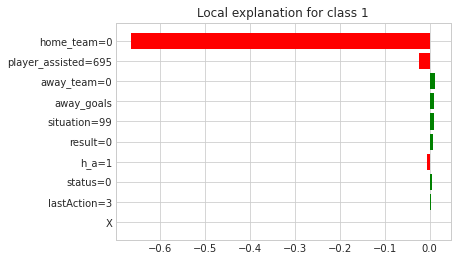

In [218]:
create_lime(any_observation_index)

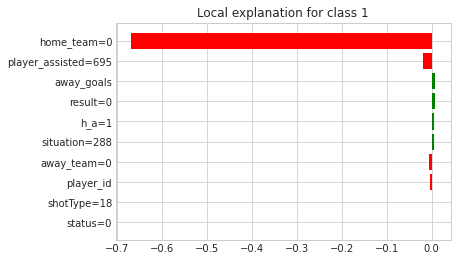

In [219]:
create_lime(any_observation_index+1)

## Conclusions

In the example above, we can clearly see that same value of a categorical variable, might result in different explanation influence (e.g `away_team`). As we might suspect, `home_team` variable value has a strong influence on the model prediction. Generally, LIME explanations are stable within some observation proximity (meaning there are quite similar for similar observations), but outliers may occur and broader investigation is necessary for each observation.